# Topicando (AlPHA)
Topicando es un proyecto que busca ayudar a obtener los tópicos más comentados por un grupo de personas, obteniendo palabras clave en forma de ranking y grafos, para poder analizar necesidades, reclamos, comentarios, tendencias e ideas de la comunidad de forma masiva.

En base a un array de frases como input se procesarán y analizarán los datos recolectados para poder tener un contexto de un tema de debate o discusión, siendo asi que:
- Presenta en una lista ordenada de mayor a menor las palabras más utilizadas diferenciadas con stemming o lemmatizing
- En base a las x palabras más usadas escogidas por estadistica o por número fijo, se crean clusters con KNN, KMeans, etc o solo con que contengan a esta palabra y se muestran grafos por cada palabra elegida como centroide
- De cada cluster o agrupación se debe mostrar las palabras más usadas

## Imports

In [1]:
import spacy
from unidecode import unidecode
from string import punctuation 
from nltk.corpus import stopwords
from collections import Counter
from spacy.matcher import Matcher
import pandas as pd
import numpy as np

In [2]:
class TopicandoV1:
    nlp = None
    phrases = []
    entities = []
    relations = []
    dictWords = {}
    
    def __init__(self, spacyLang, phrases):
        self.nlp = spacy.load(spacyLang)
        self.phrases = phrases
        self.entities = []
        self.relations = []
        self.dictWords = {}
    
    def getVectorizedPhrases(self):
        values = []
        for phrase in self.phrases:
            vector = np.zeros(300)
            doc = self.nlp(phrase)
            for token in doc:
                if not token.is_stop and not token.is_punct:
                    #print(token.text, token.pos_, token.dep_) #eliminar det
                    vector = vector + np.array(token.vector_norm)
            values.append(vector / len(doc))
        return np.array(values)

    def getMostUsedWordsInCorpus(self, useLemma = True):
        fullText = ""
        for phrase in self.phrases:
            fullText += (phrase + " ")
        doc = self.nlp(fullText)

        words = [(token.lemma_ if useLemma else token.text)
            for token in doc
            if not token.is_stop and not token.is_punct]

        word_freq = Counter(words)
        common_words = word_freq.most_common()
        return common_words
    
    def getWordCountOfEntitiesAndRelations(self):
        dictWords = {}
        for entitiesPair in self.entities:
            for word in entitiesPair:
                if word not in dictWords.keys():
                    dictWords[word] = 1
                else:
                    dictWords[word] += 1
        for relations in self.relations:
            for word in relations:
                if word not in dictWords.keys():
                    dictWords[word] = 1
                else:
                    dictWords[word] += 1

        self.dictWords = dictWords
        return dictWords

    def getMostUsedWordsOfEntitiesAndRelations(self, useLemma = True):
        self.getWordCountOfEntitiesAndRelations()
        return dict(sorted(self.dictWords.items(), key=lambda item: item[1], reverse=True))
    
    def searchEntitiesAndRelations(self):
        self.entities = []
        for phrase in self.phrases:
            self.entities.append(self.__getEntities(phrase))
        
        self.relations = []
        for phrase in self.phrases:
            self.relations.append(self.__getRelations(phrase))
    
    def getSourceEdgeTargetDataFrame(self,sourcesToSearch=[], edgesToSearch=[], targetsToSearch=[]):
        phraseLength = len(self.entities)
        sources = []
        targets = []
        edges = []
        
        for index in range(0, phraseLength):
            for relation in self.relations[index]:
                source = self.entities[index][0]
                target = self.entities[index][1]

                if (len(sourcesToSearch) + len(targetsToSearch) + len(edgesToSearch)) == 0 or (relation in edgesToSearch or source in sourcesToSearch or target in targetsToSearch):
                    sources.append(self.entities[index][0])
                    targets.append(self.entities[index][1])
                    edges.append(relation)

        sourceEdgeTargetDataframe = pd.DataFrame({'source':sources, 'target':targets, 'edge':edges})
        return sourceEdgeTargetDataframe
    
    def getSourcesEdgesTargetsEdgesArray(self, sourcesToSearch=[], edgesToSearch=[], targetsToSearch=[]):
        phraseLength = len(self.entities)
        data = []
        
        for index in range(0, phraseLength):
            for relation in self.relations[index]:
                source = self.entities[index][0]
                target = self.entities[index][1]

                if (len(sourcesToSearch) + len(targetsToSearch) + len(edgesToSearch)) == 0 or (relation in edgesToSearch or source in sourcesToSearch or target in targetsToSearch):
                    if source != '':
                        data.append([source, relation])
                    if target != '':
                        data.append([target, relation])

        return data
    
    def getSourcesTargetsArray(self, sourcesToSearch=[], edgesToSearch=[], targetsToSearch=[]):
        phraseLength = len(self.entities)
        data = []
        
        for index in range(0, phraseLength):
            for relation in self.relations[index]:
                source = self.entities[index][0]
                target = self.entities[index][1]

                if (len(sourcesToSearch) + len(targetsToSearch) + len(edgesToSearch)) == 0 or (relation in edgesToSearch or source in sourcesToSearch or target in targetsToSearch):
                    if source != '' and target != '':
                        data.append([source, target])

        return data

    def getSourceEdgeTargetEdgeDataFrame(self, sourcesToSearch=[], edgesToSearch=[], targetsToSearch=[]):
        phraseLength = len(self.entities)
        sources = []
        targets = []
        edges = []
        
        for index in range(0, phraseLength):
            for relation in self.relations[index]:
                source = self.entities[index][0]
                target = self.entities[index][1]

                if (len(sourcesToSearch) + len(targetsToSearch) + len(edgesToSearch)) == 0 or (relation in edgesToSearch or source in sourcesToSearch or target in targetsToSearch):
                    if source != '':
                        sources.append(self.entities[index][0])
                        targets.append(relation)
                        edges.append(relation)
                    if target != '':
                        sources.append(self.entities[index][1])
                        targets.append(relation)
                        edges.append(relation)

        sourceEdgeTargetDataframe = pd.DataFrame({'source':sources, 'target':targets, 'edge':edges})
        return sourceEdgeTargetDataframe

    def __getRelations(self, phrase):
        doc = self.nlp(phrase)

        matcher = Matcher(self.nlp.vocab)
        pattern = [
            {'POS':'VERB','OP':"?"},
            {'POS':'AUX','OP':"?"},
        ]

        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)

        if len(matches) == 0:
            return ["haber"]

        return [doc[match[1]:match[2]].lemma_ for match in matches]

    def __getEntities(self, phrase):
        ent1 = ""
        ent2 = ""

        prv_tok_dep = ""    
        prv_tok_text = ""   

        prefix = ""
        modifier = ""

        prv_token = None

        tokens = []

        for tok in self.nlp(phrase):
            if tok.dep_ != "punct":
                if tok.dep_ == "compound":
                    prefix = tok.text
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
                if tok.dep_.endswith("mod") == True:
                    modifier = tok.text
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
                if (tok.dep_.find("subj") == True or tok.dep_ == "subj") and tok.pos_ != "PRON":
                    ent1 = modifier + " " + prefix + " "+ tok.lemma_
                    prefix = ""
                    modifier = ""
                    prv_tok_dep = ""
                    prv_tok_text = ""
                    tokens.append(ent1)
                if tok.dep_.find("obj") == True:
                    ent2 = modifier + " " + prefix + " " + tok.lemma_
                    tokens.append(ent2)
                if tok.dep_ == "obj":
                    ent2 = tok.lemma_
                    tokens.append(ent2)
                if ent1.strip() == "" and ent2.find(tok.lemma_) == -1:
                    if tok.dep_.find("mod") == True and tok.pos_ == "ADJ":
                        ent1 = tok.lemma_
                        tokens.append(ent1)
                    if tok.pos_ == "NOUN":
                        ent1 = tok.lemma_
                        tokens.append(ent1)
                if ent2.strip() == "" and ent1.find(tok.lemma_) == -1:
                    if tok.dep_.find("mod") == True and tok.pos_ == "ADJ":
                        ent2 = tok.lemma_
                        tokens.append(ent2)
                    if tok.pos_ == "ADJ":
                        ent2 = tok.lemma_
                        tokens.append(ent2)
                    if tok.pos_ == "NOUN":
                        ent2 = tok.lemma_
                        tokens.append(ent2)
                    if (prv_token != None and prv_token.pos_ == "AUX") and (tok.pos_ == "VERB" or tok.pos_ == "ADJ"):
                        ent2 = tok.lemma_
                        tokens.append(ent2)
                prv_tok_dep = tok.dep_
                prv_tok_text = tok.text
                prv_token = tok

        #return [token.strip() for  token in tokens]
        return [ent1.strip(), ent2.strip()]

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy

## Data

In [4]:
phrases = [
    "No hay baños limpios",
    "los baños no se limpian",
    "los baños están sucios",
    "los vecinos hacen mucho ruido",
    "la vecina todo el día grita",
    "la vecina grita todo el día",
    "el vecino prende la radio todo el día",
    "ya no hay respeto a los mayores",
    "me acosan en la calle del barrio",
    "los viejos miran mucho mi cuerpo",
    "morbosean a mis familiares",
    "los viejos son pervertidos",
    "las calles están sucias",
    "ya no hay calles limpias",
    "los perros dañan la basura",
    "hay muchos perros que dejan sus desechos en la calle",
    "mucha mierda de perro en la acera",
]

In [43]:
data = pd.read_csv('./sugerencias-y-quejas-de-los-ciudadanos (1).csv',delimiter=';')
data = data.dropna()
data[data['Referencia'].apply(lambda x: isinstance(x, (str, bytes)))]
phrases = [ phrase.lower() for phrase in data.iloc[:,6].values]

## Functions

In [44]:
topicando = TopicandoV1("es_core_news_lg",phrases)

In [6]:
topicando.getMostUsedWordsInCorpus(useLemma = True)

[('calle', 4),
 ('baño', 3),
 ('vecino', 3),
 ('perro', 3),
 ('limpio', 2),
 ('sucio', 2),
 ('gritar', 2),
 ('viejo', 2),
 ('limpiar', 1),
 ('ruido', 1),
 ('vecina', 1),
 ('prender', 1),
 ('radio', 1),
 ('respeto', 1),
 ('mayor', 1),
 ('acosar', 1),
 ('barrio', 1),
 ('mirar', 1),
 ('cuerpo', 1),
 ('morbosean', 1),
 ('familiar', 1),
 ('pervertido', 1),
 ('dañar', 1),
 ('basura', 1),
 ('dejar', 1),
 ('desecho', 1),
 ('mierda', 1),
 ('acera', 1)]

In [45]:
topicando.searchEntitiesAndRelations()

In [29]:
topicando.getWordCountOfEntitiesAndRelations()

{'limpio': 2,
 'baño': 3,
 '': 3,
 'sucio': 2,
 'vecino': 3,
 'ruido': 1,
 'día': 2,
 'vecina': 1,
 'radio': 1,
 'respeto': 1,
 'calle': 4,
 'yo': 1,
 'viejo': 2,
 'cuerpo': 1,
 'familiar': 1,
 'pervertir': 2,
 'perro': 1,
 'basura': 1,
 'desecho': 1,
 'mierda': 1,
 'acera': 1,
 'haber': 5,
 'limpiar': 1,
 'estar': 2,
 'hacer': 1,
 'gritar': 2,
 'prender': 1,
 'acosar': 1,
 'mirar': 1,
 'morbosear': 1,
 'ser': 1,
 'dañar': 1,
 'dejar': 1}

In [9]:
topicando.getMostUsedWordsOfEntitiesAndRelations()

{'haber': 5,
 'calle': 4,
 'baño': 3,
 '': 3,
 'vecino': 3,
 'limpio': 2,
 'sucio': 2,
 'día': 2,
 'viejo': 2,
 'pervertir': 2,
 'estar': 2,
 'gritar': 2,
 'ruido': 1,
 'vecina': 1,
 'radio': 1,
 'respeto': 1,
 'yo': 1,
 'cuerpo': 1,
 'familiar': 1,
 'perro': 1,
 'basura': 1,
 'desecho': 1,
 'mierda': 1,
 'acera': 1,
 'limpiar': 1,
 'hacer': 1,
 'prender': 1,
 'acosar': 1,
 'mirar': 1,
 'morbosear': 1,
 'ser': 1,
 'dañar': 1,
 'dejar': 1}

In [10]:
kg_df = topicando.getSourceEdgeTargetDataFrame()
kg_df2 = topicando.getSourceEdgeTargetDataFrame(sourcesToSearch=["limpio","baño"])
print(kg_df[0:5])
print(kg_df2[0:5])

   source target     edge
0  limpio   baño    haber
1    baño         limpiar
2    baño  sucio    estar
3  vecino  ruido    hacer
4  vecino    día   gritar
   source target     edge
0  limpio   baño    haber
1    baño         limpiar
2    baño  sucio    estar
3  limpio  calle    haber


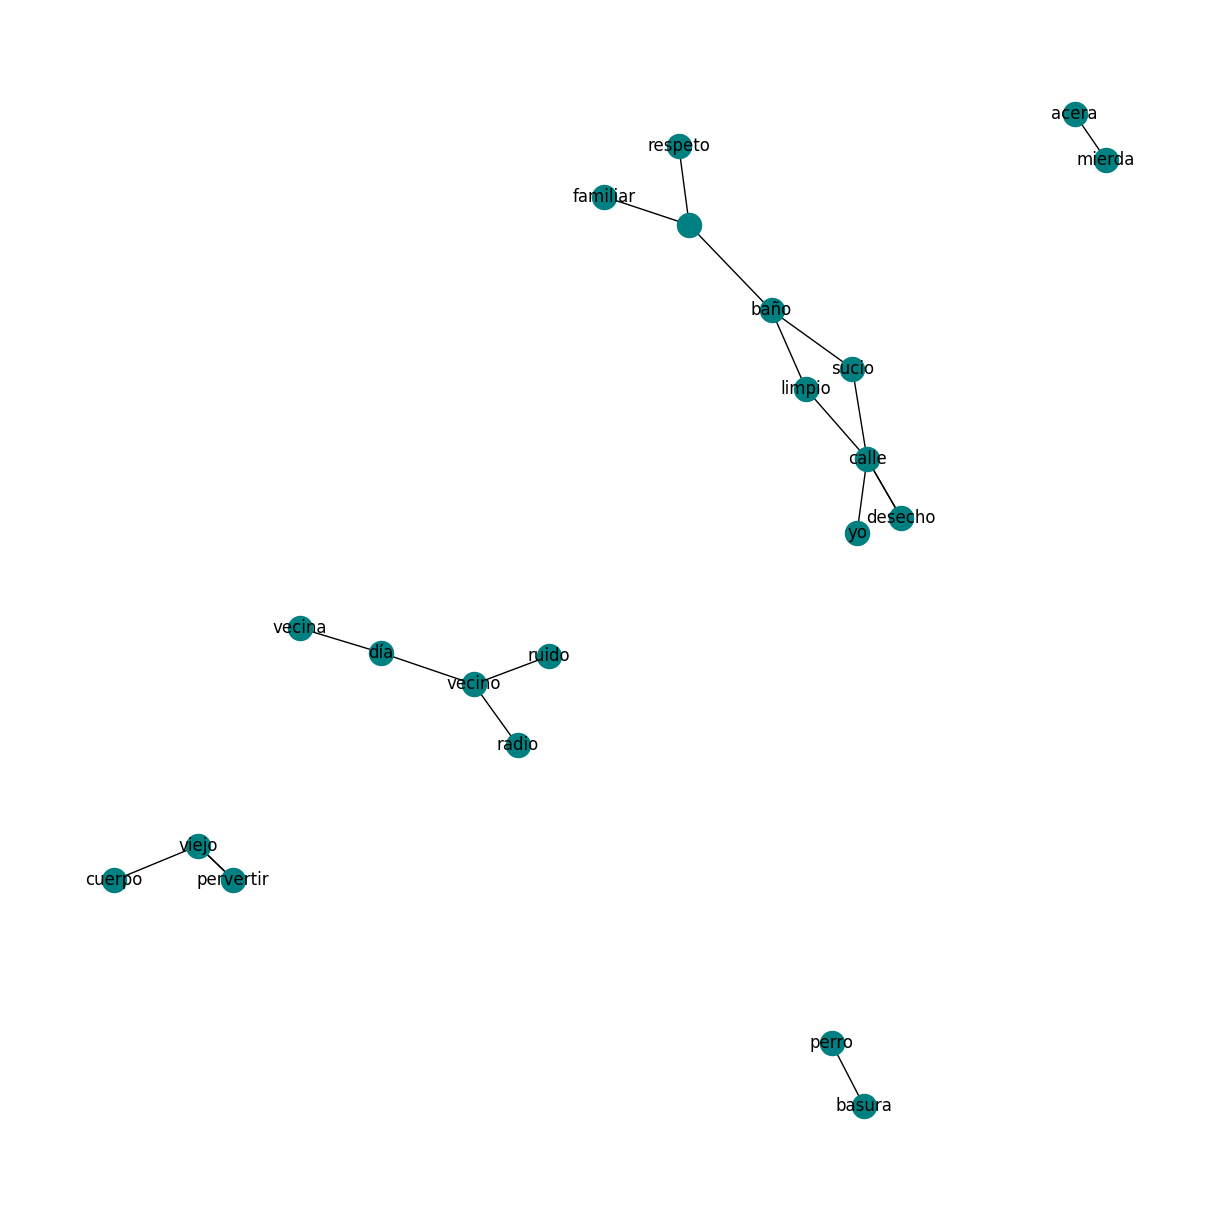

In [11]:
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

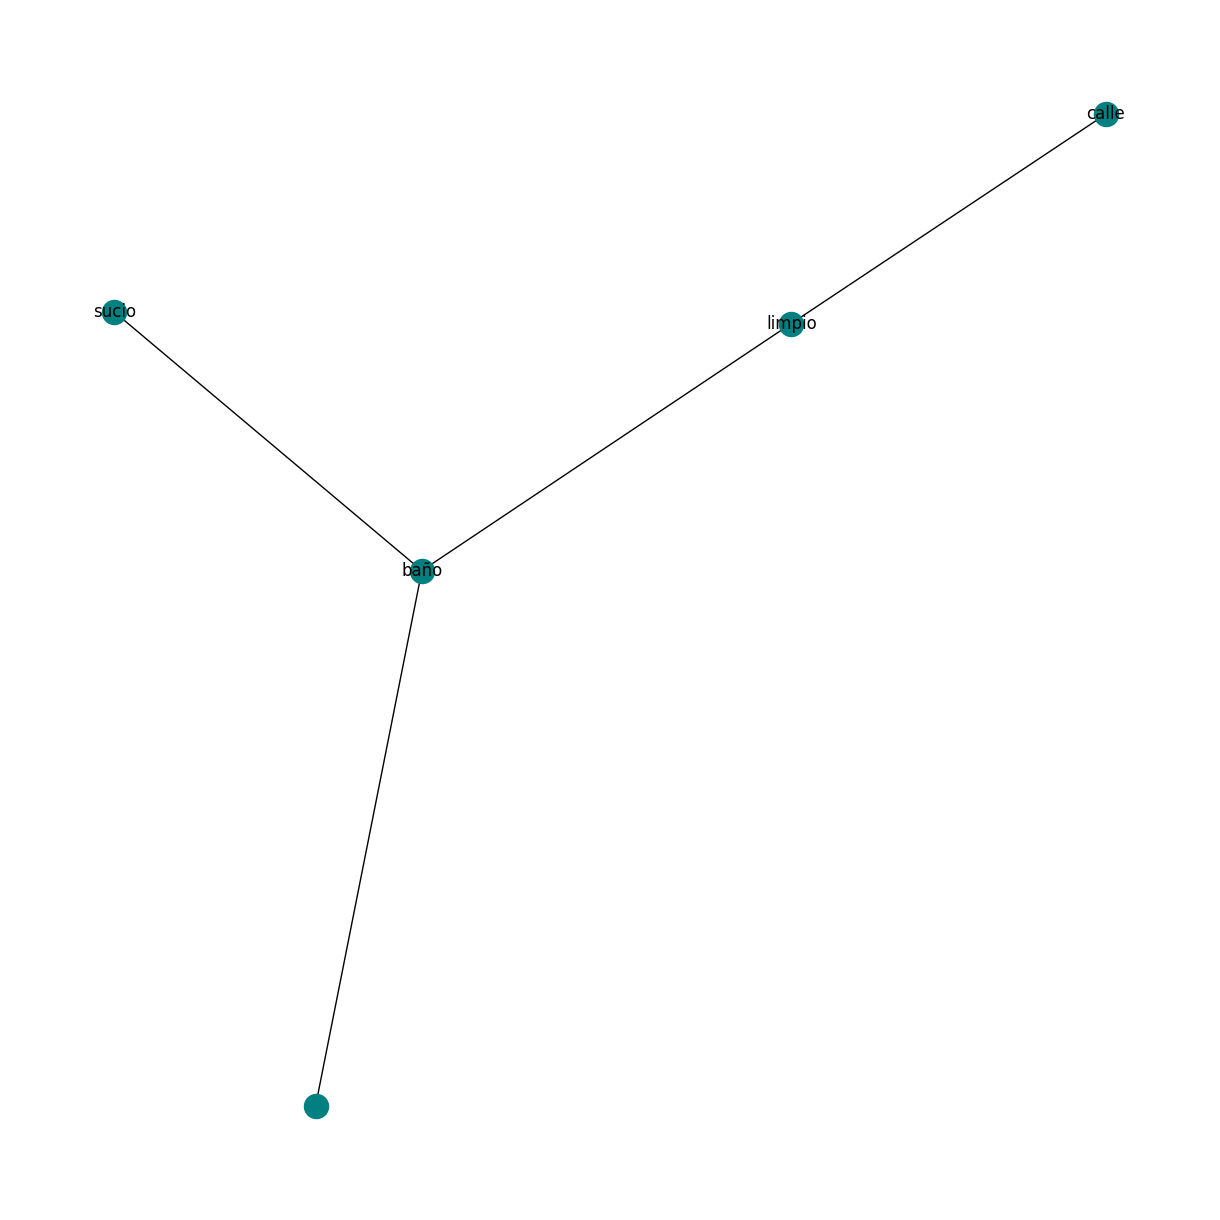

In [12]:
G = nx.from_pandas_edgelist(kg_df2, "source", "target", edge_attr=True, create_using=nx.MultiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='teal', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [16]:
kg_df = topicando.getSourceEdgeTargetEdgeDataFrame()
kg_df2 = topicando.getSourceEdgeTargetEdgeDataFrame(sourcesToSearch=["limpio","baño"])
print(kg_df[0:5])
print(kg_df2[0:5])

   source   target     edge
0  limpio    haber    haber
1    baño    haber    haber
2    baño  limpiar  limpiar
3    baño    estar    estar
4   sucio    estar    estar
   source   target     edge
0  limpio    haber    haber
1    baño    haber    haber
2    baño  limpiar  limpiar
3    baño    estar    estar
4   sucio    estar    estar


## Html Output

In [24]:
from collections.abc import Iterable
from highcharts import Highchart
from IPython.core.display import HTML
import json
from IPython.display import Javascript

In [8]:
%%javascript
require.config({
    packages: [{
        name: 'highcharts',
        main: 'highcharts'
    }],
    paths: {
        'highcharts': 'https://code.highcharts.com',
        'networkgraph': 'https://code.highcharts.com/modules/networkgraph.js'
    }
});

<IPython.core.display.Javascript object>

In [31]:
import json
from IPython.display import Javascript

chart_data = []

for index in range(0, len(source) - 1):
    if (source[index] != ""):
        chart_data.append([source[index], relations[index]])
    if (target[index] != ""):
        chart_data.append([target[index], relations[index]])
    if (source[index] != "" and target[index] != ""):
        chart_data.append([source[index], target[index]])

Javascript("window.chartData={};".format(json.dumps(chart_data)))

NameError: name 'source' is not defined

In [14]:
topicando.getSourcesTargetsArray()

[['limpio', 'baño'],
 ['baño', 'sucio'],
 ['vecino', 'ruido'],
 ['vecino', 'día'],
 ['vecina', 'día'],
 ['vecino', 'radio'],
 ['calle', 'yo'],
 ['viejo', 'cuerpo'],
 ['viejo', 'pervertir'],
 ['viejo', 'pervertir'],
 ['calle', 'sucio'],
 ['limpio', 'calle'],
 ['perro', 'basura'],
 ['calle', 'desecho'],
 ['calle', 'desecho'],
 ['mierda', 'acera']]

In [46]:
chart_data = []
nodes_filtered = []
for i in topicando.getSourcesTargetsArray():
    if i[0] not in nodes_filtered:
        nodes_filtered.append(i[0])
    if i[1] not in nodes_filtered:
        nodes_filtered.append(i[1])
    chart_data.append([i[0],i[1]])

Javascript("window.chartData={};".format(json.dumps(chart_data)))

<IPython.core.display.Javascript object>

In [47]:
topicando.getWordCountOfEntitiesAndRelations()        
nodes = []
for word in topicando.dictWords.keys():
    if word != '' and word in nodes_filtered:
        nodes.append({
            "id": word,
            "marker": {
                "radius": topicando.dictWords[word]
            }
        })

Javascript("window.nodes={};".format(json.dumps(nodes)))

<IPython.core.display.Javascript object>

In [48]:
%%javascript
// Since I append the div later, sometimes there are multiple divs.
$("#container").remove();

// Make the cdiv to contain the chart.
element.append('<div id="container" style="min-width: 310px; min-height: 600px; margin: 0 auto"></div>');

console.log("init");
console.log(window.chartData);
console.log(window.nodes);

// Require highcarts and make the chart.
require([
    'highcharts',
    'highcharts/modules/exporting',
    'highcharts/modules/accessibility',
    'highcharts/modules/networkgraph'
], function (Highcharts) {

    console.log("WORKING");
    $('#container').highcharts({
        chart: {
        type: 'networkgraph',
        height: '100%'
      },
      title: {
        text: ''
      },
      subtitle: {
        text: ''
      },
        tooltip: {
    formatter: function () {
        console.log(this)
      return "<b>" + this.key + "</b>: " + this.point.radius;
    }
  },
      plotOptions: {
        networkgraph: {
          keys: ['from', 'to'],
          layoutAlgorithm: {
            enableSimulation: false,//true
            friction: -0.9
          }
        }
      },
      series: [{
          colorByPoint: true,
        accessibility: {
          enabled: false
        },
        dataLabels: {
          enabled: true,
          linkFormat: '',
        },
        id: 'lang-tree',
        data: window.chartData,
        nodes: window.nodes
      }]
    });
});

<IPython.core.display.Javascript object>